# Test 10-5-3 Network
Purpose: To test the new implementation of Predictive Coding.

In [9]:
import numpy as np
import PCNetwork
import PCLayer
import PCConnection
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

%load_ext autoreload
%autoreload 2

dtype = torch.float32
if torch.cuda.is_available():
    device = torch.device("cuda:0") # Uncomment this to run on GPU
else:
    device = torch.device("cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dataset

In [38]:
# This creates a dataset

n_classes = 3
hidden_dim = 5
sensory_dim = 10

seed = 333 #2950
torch.manual_seed(seed)
np.random.seed(seed)
B = torch.eye(n_classes)
X = 3.*(torch.rand((sensory_dim, n_classes)) - 0.5)
A = X.T
print('Input vectors')
print(A)
print('Target vectors')
print(B)

Input vectors
tensor([[-1.2524,  0.8191,  0.2002,  0.3163,  0.7792,  0.9187,  0.3398, -0.9419,
         -1.1476,  0.3465],
        [ 1.0601, -0.5350,  1.2466, -0.4028, -1.0083,  0.9697, -0.1861, -0.0503,
         -0.6210,  0.5418],
        [ 0.3342, -0.8981, -0.3216, -0.3966,  1.3320, -0.5228, -0.8623,  1.3187,
         -1.0590, -0.6484]])
Target vectors
tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]])


In [39]:
class SimpleDataset(Dataset):
    def __init__(self, A, B, n=300, noise=0.1):
        self.samples = []
        self.n_classes = len(A)
        self.input_dim = len(A[0])
        for i in range(n):
            r = np.random.randint(self.n_classes)
            sample = [A[r]+noise*torch.randn_like(A[r]), B[r]]
            self.samples.append(sample)
        
    def __getitem__(self, idx):
        return self.samples[idx]
        
    def __len__(self):
        return len(self.samples)
    
    def Inputs(self):
        x = []
        for s in self.samples:
            x.append(s[0])
        return torch.stack(x)
    
    def Targets(self):
        t = []
        for s in self.samples:
            t.append(s[1])
        return torch.stack(t)
            
    def InputsOfClass(self, c):
        x = []
        for s in self.samples:
            if torch.argmax(s[1])==c:
                x.append(s[0])
        return torch.stack(x)
    
    def ClassMean(self):
        xmean = []
        for c_idx in range(self.n_classes):
            classmean = torch.mean(self.InputsOfClass(c_idx), axis=0)
            xmean.append(classmean)
        return torch.stack(xmean)
            
    def Plot(self, labels=[], idx=(1,2), equal=True):
        X = self.Inputs()
        if len(labels)==0:
            labels = self.Targets()
        colour_options = ['y', 'r', 'g', 'b', 'k']
        cidx = torch.argmax(labels, axis=1)
        colours = [colour_options[k] for k in cidx]
        plt.scatter(X[:,idx[0]], X[:,idx[1]], color=colours, marker='.')

        if equal:
            plt.axis('equal');

In [40]:
blah = SimpleDataset(A, B, n=300, noise=0.1)

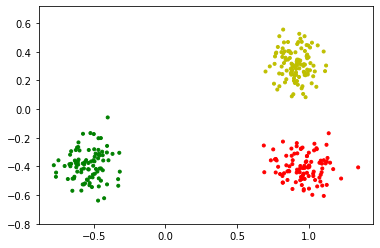

In [41]:
blah.Plot(idx=(5,3))

In [42]:
blah.ClassMean()

tensor([[-1.2494,  0.8050,  0.2003,  0.3127,  0.7816,  0.9103,  0.3439, -0.9358,
         -1.1490,  0.3393],
        [ 1.0604, -0.5293,  1.2568, -0.4049, -1.0225,  0.9649, -0.1756, -0.0406,
         -0.6283,  0.5438],
        [ 0.3458, -0.8952, -0.3165, -0.3904,  1.3361, -0.5376, -0.8609,  1.3236,
         -1.0514, -0.6557]])

# Create Network

In [43]:
net = PCNetwork.PCNetwork()
net.AddLayer(PCLayer.PCLayer(n=10))  # input
net.AddLayer(PCLayer.PCLayer(n=5))   # e1
net.AddLayer(PCLayer.PCLayer(n=5))   # v1
net.AddLayer(PCLayer.PCLayer(n=3))   # e2
net.AddLayer(PCLayer.PCLayer(n=3))   # v2

af = 'identity'
sym = True
# Use identity activation for input layer to make it comparable to a FF net
net.Connect(v_idx=0, e_idx=1, type='general', sym=sym, act_text='identity')
net.Connect(e_idx=1, v_idx=2, type='1to1')
net.Connect(v_idx=2, e_idx=3, type='general', sym=sym, act_text=af)
net.Connect(e_idx=3, v_idx=4, type='1to1')

net.SetTau(0.05)

# Performance Before Training

In [44]:
test_ds = SimpleDataset(A, B, n=200, noise=0.2)

In [45]:
lbls = net.Predict(test_ds.Inputs(), T=2.)

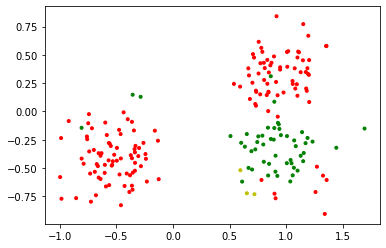

In [46]:
test_ds.Plot(labels=lbls, idx=(5,3))

# Training

In [47]:
train_ds = SimpleDataset(A, B, n=200, noise=0.2)
dl = DataLoader(train_ds, batch_size=25, shuffle=True)

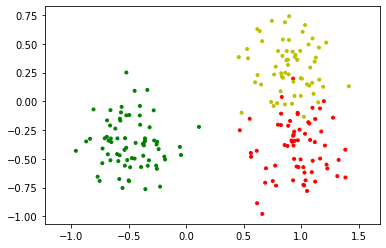

In [48]:
train_ds.Plot(idx=(5,3))

In [49]:
net.SetDynamicWeightDecay(0.2, 0.5)
net.Learn(dl, T=3., epochs=3)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:28<00:00,  9.65s/it]


# Classification

In [50]:
net.Reset(random=1.)
net.lyr[-1].Probe(True)
net.Predict(A, T=2.)

tensor([[ 0.9509,  0.0183,  0.0309],
        [ 0.0488,  0.9385,  0.0128],
        [-0.0250,  0.0242,  1.0007]])

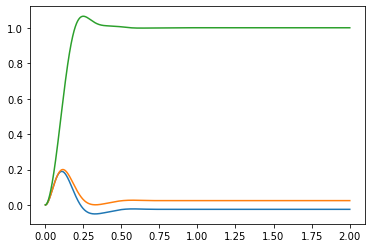

In [51]:
net.lyr[-1].Plot(net.t_history, idx=2);

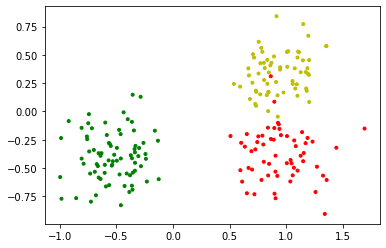

In [52]:
sidx = (5,3)
test_ds.Plot(labels=net.Predict(test_ds.Inputs(), T=2.), idx=sidx)